In [205]:
import pandas as pd
import numpy as np
import sklearn
import math
import matplotlib.pyplot as plt

In [206]:
df = pd.read_csv('model_data.csv')

In [207]:
df.head()

,Unnamed: 0,Year,Player,Pos,Age,Tm,G,MP,PER,TS%,...,DBPM,3P%,2P%,FT%,TmNetRtg,Next Rtg,Next WS,Veteran Value,VV Class,Starters
0,1,1997,Vinny Del,SG,30.0,SAS,72.0,2243.0,14.4,0.529,...,-2.3,0.314,0.501,0.868,-8.8,4.4,3.7,2903.225806,0,1
1,3,1997,Avery Johnson,PG,31.0,SAS,76.0,2472.0,15.0,0.517,...,-3.0,0.231,0.487,0.690,-8.8,4.4,6.7,14558.823529,0,1
2,7,1997,Charles Barkley,PF,33.0,HOU,53.0,2009.0,23.0,0.581,...,2.8,0.283,0.569,0.694,4.7,-0.9,8.6,-1276.595745,1,1
3,8,1997,Clyde Drexler,SG,34.0,HOU,62.0,2271.0,19.9,0.548,...,1.7,0.355,0.493,0.750,4.7,-0.9,6.8,-2407.407407,1,1
4,9,1997,Mario Elie,SF,33.0,HOU,78.0,2687.0,14.3,0.662,...,0.1,0.420,0.572,0.896,4.7,-0.9,3.8,-8595.505618,1,1


## Pre-Processing

In [208]:
df.columns

Index(['Unnamed: 0', 'Year', 'Player', 'Pos', 'Age', 'Tm', 'G', 'MP', 'PER',
       'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'AST%', 'STL%', 'BLK%', 'TOV%',
       'USG%', 'OWS', 'DWS', 'WS', 'WS/48', 'OBPM', 'DBPM', '3P%', '2P%',
       'FT%', 'TmNetRtg', 'Next Rtg', 'Next WS', 'Veteran Value', 'VV Class',
       'Starters'],
      dtype='object')

<AxesSubplot:ylabel='Frequency'>

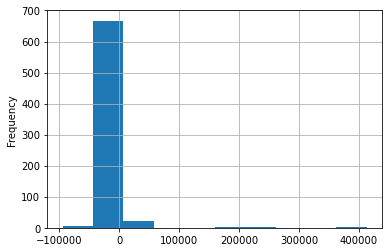

In [209]:
df['Veteran Value'].plot.hist(grid=True)

In [210]:
# calculate summary statistics
data = df['Veteran Value']
data_mean, data_std = np.mean(data), np.std(data)
# identify outliers
cut_off = data_std * 3
lower, upper = data_mean - cut_off, data_mean + cut_off
print(lower, upper)

-63806.593259548616 63843.64009831145


In [211]:
outliers = [x[0] for x in enumerate(df['Veteran Value']) if x[1] < lower or x[1] > upper]
outliers

[30, 201, 209, 210, 212, 462, 463, 507]

In [212]:
df.drop(index=outliers,inplace=True)

<AxesSubplot:ylabel='Frequency'>

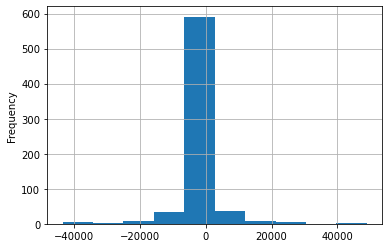

In [213]:
df['Veteran Value'].plot.hist(grid=True)

[  4.   2.   8.  35. 591.  36.   7.   5.   0.   1.] [-43636.36363636 -34374.28977273 -25112.21590909 -15850.14204545
  -6588.06818182   2674.00568182  11936.07954545  21198.15340909
  30460.22727273  39722.30113636  48984.375     ]


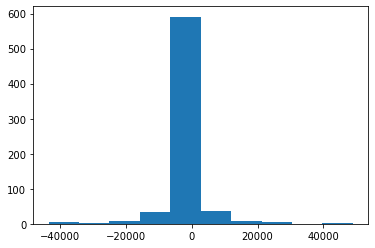

In [214]:
n, bins, patches = plt.hist(df['Veteran Value'])
print(n,bins)

In [215]:
target = df['Veteran Value']

def getClass(vv):
    d25, d50, d75 = df['Veteran Value'].describe()['25%'], df['Veteran Value'].describe()['50%'], df['Veteran Value'].describe()['75%']
    if vv < -5000:
        return 0
    elif -5000 <= vv < -1000:
        return 1
    elif -1000 <= vv < 0:
        return 2
    elif 0 <= vv < 1250:
        return 3
    elif 1250 <= vv < 8500:
        return 4
    elif vv > 8500:
        return 5
    
df['VV Class'] = [getClass(vv) for vv in df['Veteran Value']]
target_class = df['VV Class']

In [216]:
df['Veteran Value'].describe()

count      689.000000
mean      -619.597175
std       6033.409010
min     -43636.363636
25%       -142.227279
50%          4.032345
75%         72.881356
max      48984.375000
Name: Veteran Value, dtype: float64

In [217]:
df.drop(['Unnamed: 0','Age','Year','Player','Pos','Tm','Next WS','WS','Next Rtg','TmNetRtg','Veteran Value', 'VV Class'], axis=1, inplace=True)

In [218]:
df.columns

Index(['G', 'MP', 'PER', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'AST%', 'STL%',
       'BLK%', 'TOV%', 'USG%', 'OWS', 'DWS', 'WS/48', 'OBPM', 'DBPM', '3P%',
       '2P%', 'FT%', 'Starters'],
      dtype='object')

In [219]:
#try scaling values

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)


In [220]:
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(scaled_data, target_class.values, random_state=42)

### Logistic Regression Classifier

In [221]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
clf = LogisticRegression(tol=1e-4, max_iter=1000, random_state=0).fit(xtrain, ytrain)
clf.predict(xtest)
clf.predict_proba(xtest)
clf.score(xtest,ytest)

0.6127167630057804

In [222]:
metrics.roc_auc_score(ytest,clf.predict_proba(xtest),multi_class='ovr')

0.585949677390985

### KNN Classifier

In [223]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

n_neighbors=15
neigh = KNeighborsClassifier(n_neighbors)
neigh.fit(xtrain, ytrain)

KNeighborsClassifier(n_neighbors=15)

In [224]:
neigh.predict_proba(xtest)
neigh.score(xtest,ytest)

0.6011560693641619

In [225]:
metrics.roc_auc_score(ytest,neigh.predict_proba(xtest),multi_class='ovr')

0.5476628548923504

### Random Forests Classifier

In [226]:
from sklearn.ensemble import RandomForestClassifier


rf = RandomForestClassifier(n_estimators=250, max_depth=50, min_samples_leaf=10, min_samples_split = 10, max_features=10)
rf.fit(xtrain, ytrain)
rf.predict_proba(xtest)
rf.score(xtest,ytest)

0.6127167630057804

In [227]:
metrics.roc_auc_score(ytest,rf.predict_proba(xtest),multi_class='ovr')

0.5734543793476843

### Boosted Classifier


In [228]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

abc = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(min_samples_split=2**6, max_depth=10), 
                         n_estimators=225, learning_rate=0.5)
abc.fit(xtrain, ytrain)
abc.predict_proba(xtest)
abc.score(xtest,ytest)

0.6127167630057804

In [229]:
metrics.roc_auc_score(ytest,abc.predict_proba(xtest),multi_class='ovr')

0.6224517783828478

### Neural Network

In [230]:
from sklearn.neural_network import MLPClassifier

mlpc = MLPClassifier(hidden_layer_sizes=(1000,100,10),activation='relu',learning_rate_init=0.001,batch_size=256, verbose=True,max_iter=100)
mlpc.fit(xtrain, ytrain)
mlpc.predict_proba(xtest)
mlpc.score(xtest,ytest)


Iteration 1, loss = 1.54537677
Iteration 2, loss = 1.43607934
Iteration 3, loss = 1.41080242
Iteration 4, loss = 1.40958865
Iteration 5, loss = 1.40133108
Iteration 6, loss = 1.40883602
Iteration 7, loss = 1.41613404
Iteration 8, loss = 1.40872613
Iteration 9, loss = 1.39286318
Iteration 10, loss = 1.38064511
Iteration 11, loss = 1.37606865
Iteration 12, loss = 1.37588266
Iteration 13, loss = 1.37682137
Iteration 14, loss = 1.37077893
Iteration 15, loss = 1.36130603
Iteration 16, loss = 1.36065045
Iteration 17, loss = 1.36791567
Iteration 18, loss = 1.36667656
Iteration 19, loss = 1.35849617
Iteration 20, loss = 1.34900720
Iteration 21, loss = 1.34006414
Iteration 22, loss = 1.33767023
Iteration 23, loss = 1.33791462
Iteration 24, loss = 1.33209519
Iteration 25, loss = 1.32580037
Iteration 26, loss = 1.32233123
Iteration 27, loss = 1.32084276
Iteration 28, loss = 1.31658696
Iteration 29, loss = 1.31304345
Iteration 30, loss = 1.30960103
Iteration 31, loss = 1.30654339
Iteration 32, los

/opt/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


0.6127167630057804

In [231]:
metrics.roc_auc_score(ytest,mlpc.predict_proba(xtest),multi_class='ovr')

0.5052255144064991

### Voting Classifier

In [232]:
from sklearn.ensemble import VotingClassifier 
from sklearn.ensemble import StackingClassifier

estimator = [] 
estimator.append(('RFC',rf))
estimator.append(('LRC',clf))
estimator.append(('ABC',abc))
estimator.append(('MLP',mlpc))


vot_soft = VotingClassifier(estimators = estimator, voting='soft', verbose=True) 
vot_soft.fit(xtrain, ytrain)
vot_soft.predict_proba(xtest)
vot_soft.score(xtest,ytest)

[Voting] ...................... (1 of 4) Processing RFC, total=   1.2s
[Voting] ...................... (2 of 4) Processing LRC, total=   0.1s
[Voting] ...................... (3 of 4) Processing ABC, total=   1.7s
Iteration 1, loss = 1.79620093
Iteration 2, loss = 1.69729123
Iteration 3, loss = 1.63665103
Iteration 4, loss = 1.60495958
Iteration 5, loss = 1.59310603
Iteration 6, loss = 1.58530814
Iteration 7, loss = 1.57792148
Iteration 8, loss = 1.57043278
Iteration 9, loss = 1.56495241
Iteration 10, loss = 1.55564391
Iteration 11, loss = 1.54615032
Iteration 12, loss = 1.54004950
Iteration 13, loss = 1.53371703
Iteration 14, loss = 1.52536485
Iteration 15, loss = 1.51915247
Iteration 16, loss = 1.51600840
Iteration 17, loss = 1.50931380
Iteration 18, loss = 1.50078575
Iteration 19, loss = 1.48841910
Iteration 20, loss = 1.48702059
Iteration 21, loss = 1.49136461
Iteration 22, loss = 1.48920037
Iteration 23, loss = 1.47943456
Iteration 24, loss = 1.46654206
Iteration 25, loss = 1.45435

/opt/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


0.6127167630057804

In [233]:
metrics.roc_auc_score(ytest,vot_soft.predict_proba(xtest),multi_class='ovr')

0.5704413751501483

## Test on Veterans of 2021-2022 Season

Data Cleaning for NBA 2021-2022

In [296]:
import pandas as pd
import numpy as np
data = pd.read_csv('compiled.csv')

In [297]:
data1 = data[data['Year']==2020]
data2 = data[data['Year']==2021]
new_data = pd.concat([data1,data2])
data2 = data2.copy()

In [298]:
import math
next_rtg = []
for index, row in new_data.iterrows():
    current_team = row['Tm']
    next_year = row['Year'] + 1
    
    try:
        rtg = new_data.loc[(new_data['Tm'] == current_team) & (new_data['Year'] == next_year)].iloc[0]['TmNetRtg']
        next_rtg.append(rtg)
    except:
        next_rtg.append(math.nan)

In [299]:
new_data['Next Rtg'] = next_rtg
#new_data = new_data.dropna()

In [300]:
new_data.tail()

,Year,Player,Pos,Age,Tm,G,MP,PER,TS%,3PAr,...,DWS,WS,WS/48,OBPM,DBPM,3P%,2P%,FT%,TmNetRtg,Next Rtg
1462,2021,Garrett Temple,SG,34.0,CHI,56.0,1528.0,8.2,0.525,0.525,...,1.4,1.6,0.050,-3.3,-0.1,0.335,0.503,0.800,-1.1,NaN
1463,2021,Thaddeus Young,PF,32.0,CHI,68.0,1652.0,20.3,0.578,0.068,...,2.2,5.1,0.147,2.0,1.2,0.267,0.580,0.628,-1.1,NaN
1464,2021,Nikola Vuƒçeviƒá,C,30.0,ORL,44.0,1500.0,23.5,0.565,0.317,...,1.8,3.9,0.125,5.5,0.1,0.406,0.515,0.827,-9.3,NaN
1465,2021,Kemba Walker,PG,30.0,BOS,43.0,1369.0,17.7,0.559,0.522,...,1.1,3.3,0.115,2.5,-0.7,0.360,0.486,0.899,1.2,NaN
1466,2021,John Wall,PG,30.0,HOU,40.0,1288.0,15.4,0.503,0.343,...,0.8,-0.2,-0.007,1.4,-1.6,0.317,0.449,0.749,-7.4,NaN


In [301]:
next_ws = []
for index, row in new_data.iterrows():
    current_player = row['Player']
    next_year = row['Year'] + 1
    
    try:
        ws = new_data.loc[(new_data['Player'] == current_player) & (new_data['Year'] == next_year)].iloc[0]['WS']
        next_ws.append(ws)
    except:
        next_ws.append(math.nan)

In [302]:
new_data['Next WS'] = next_ws
new_data.head()

,Year,Player,Pos,Age,Tm,G,MP,PER,TS%,3PAr,...,WS,WS/48,OBPM,DBPM,3P%,2P%,FT%,TmNetRtg,Next Rtg,Next WS
1377,2020,LaMarcus Aldridge,C,34.0,SAS,53.0,1754.0,19.7,0.571,0.198,...,4.5,0.122,1.8,-0.5,0.389,0.519,0.827,-0.9,-1.5,NaN
1378,2020,DeMar DeRozan,SF,30.0,SAS,68.0,2316.0,21.6,0.603,0.033,...,7.3,0.151,2.3,-0.4,0.257,0.540,0.845,-0.9,-1.5,7.4
1379,2020,Rudy Gay,PF,33.0,SAS,67.0,1461.0,15.4,0.553,0.369,...,2.1,0.068,0.0,-0.9,0.336,0.511,0.882,-0.9,-1.5,1.7
1380,2020,Patty Mills,PG,31.0,SAS,66.0,1485.0,14.8,0.592,0.674,...,2.8,0.091,1.2,-1.2,0.382,0.533,0.866,-0.9,-1.5,2.2
1381,2020,Carmelo Anthony,PF,35.0,POR,58.0,1902.0,12.4,0.525,0.289,...,1.3,0.033,-1.8,-1.8,0.385,0.448,0.845,-1.1,1.8,2.6


In [303]:
new_data.head()

,Year,Player,Pos,Age,Tm,G,MP,PER,TS%,3PAr,...,WS,WS/48,OBPM,DBPM,3P%,2P%,FT%,TmNetRtg,Next Rtg,Next WS
1377,2020,LaMarcus Aldridge,C,34.0,SAS,53.0,1754.0,19.7,0.571,0.198,...,4.5,0.122,1.8,-0.5,0.389,0.519,0.827,-0.9,-1.5,NaN
1378,2020,DeMar DeRozan,SF,30.0,SAS,68.0,2316.0,21.6,0.603,0.033,...,7.3,0.151,2.3,-0.4,0.257,0.540,0.845,-0.9,-1.5,7.4
1379,2020,Rudy Gay,PF,33.0,SAS,67.0,1461.0,15.4,0.553,0.369,...,2.1,0.068,0.0,-0.9,0.336,0.511,0.882,-0.9,-1.5,1.7
1380,2020,Patty Mills,PG,31.0,SAS,66.0,1485.0,14.8,0.592,0.674,...,2.8,0.091,1.2,-1.2,0.382,0.533,0.866,-0.9,-1.5,2.2
1381,2020,Carmelo Anthony,PF,35.0,POR,58.0,1902.0,12.4,0.525,0.289,...,1.3,0.033,-1.8,-1.8,0.385,0.448,0.845,-1.1,1.8,2.6


In [304]:
#change_rtg.replace([np.inf, -np.inf], np.nan, inplace=True)
#change_rtg.dropna(inplace=True)

In [305]:
#change_ws.dropna(inplace=True)

In [306]:
new_data = new_data.dropna()

In [307]:
change_rtg = 100*((new_data['Next Rtg'] - new_data['TmNetRtg']).divide(new_data['TmNetRtg'].abs()))

In [308]:
change_ws = 100*((new_data['Next WS'] - new_data['WS'])/abs(new_data['WS']))

In [309]:
z = zip(change_ws, change_rtg)
targets = []
target_class = []
#tgt represents decline
for t in z:
    d_ws = float(t[0])
    d_rtg = float(t[1])
    RTG_UP = (d_rtg > 0)
    RTG_DOWN = (d_rtg < 0)
    WS_UP = (d_ws >= 0)
    
    
    if RTG_UP:
        vv = d_rtg * d_ws
    else:
        if WS_UP:
            vv = -1*d_rtg 
        else:
            vv = d_rtg / d_ws
        
        
    
    targets.append(vv)
    target_class.append(0 if vv >= 0 else 1)
    
new_data['Veteran Value'] = targets
new_data['VV Class'] = target_class

In [311]:
def getClass(vv):
    if vv < -5000:
        return 0
    elif -5000 <= vv < -1000:
        return 1
    elif -1000 <= vv < 0:
        return 2
    elif 0 <= vv < 1250:
        return 3
    elif 1250 <= vv < 8500:
        return 4
    elif vv > 8500:
        return 5
    
new_data['VV Class'] = [getClass(vv) for vv in new_data['Veteran Value']]
target_class = new_data['VV Class']

In [312]:
new_data.sort_values(by=['Veteran Value'])

,Year,Player,Pos,Age,Tm,G,MP,PER,TS%,3PAr,...,OBPM,DBPM,3P%,2P%,FT%,TmNetRtg,Next Rtg,Next WS,Veteran Value,VV Class
1416,2020,Paul Millsap,PF,34.0,DEN,51.0,1240.0,16.9,0.591,0.283,...,0.3,-0.2,0.435,0.500,0.816,2.2,4.8,3.2,-1012.987013,1
1388,2020,Eric Bledsoe,PG,30.0,MIL,61.0,1646.0,17.6,0.571,0.306,...,0.8,1.1,0.344,0.533,0.790,9.4,5.8,2.3,0.667124,3
1391,2020,Wesley Matthews,SG,33.0,MIL,67.0,1635.0,8.1,0.547,0.704,...,-2.6,0.7,0.364,0.472,0.765,9.4,5.8,1.7,0.817021,3
1410,2020,LeBron James,PG,35.0,LAL,67.0,2316.0,25.5,0.577,0.326,...,6.6,1.8,0.348,0.564,0.693,5.6,2.9,5.6,1.125000,3
1409,2020,Dwight Howard,C,34.0,LAL,69.0,1306.0,18.7,0.696,0.018,...,-1.0,1.2,0.600,0.732,0.514,5.6,2.9,4.0,1.859694,3
1401,2020,Kyle Lowry,PG,33.0,TOR,58.0,2098.0,17.7,0.590,0.580,...,2.2,1.0,0.352,0.504,0.857,6.1,-0.4,4.1,2.350530,3
1380,2020,Patty Mills,PG,31.0,SAS,66.0,1485.0,14.8,0.592,0.674,...,1.2,-1.2,0.382,0.533,0.866,-0.9,-1.5,2.2,3.111111,3
1379,2020,Rudy Gay,PF,33.0,SAS,67.0,1461.0,15.4,0.553,0.369,...,0.0,-0.9,0.336,0.511,0.882,-0.9,-1.5,1.7,3.500000,3
1412,2020,Justin Holiday,SG,30.0,IND,73.0,1826.0,12.1,0.585,0.681,...,-0.5,1.8,0.405,0.477,0.791,1.9,0.1,3.1,3.617225,3
1390,2020,Brook Lopez,C,31.0,MIL,68.0,1817.0,15.0,0.551,0.484,...,-0.4,2.5,0.314,0.549,0.836,9.4,5.8,5.3,10.531915,3


In [313]:
new_data.drop(['Age','Year','Player','Pos','Tm','Next WS','WS','Next Rtg','TmNetRtg','Veteran Value', 'VV Class'], axis=1, inplace=True)

In [314]:
data2.drop(['Age','Year','Player','Pos','Tm','WS','TmNetRtg'], axis=1, inplace=True)
data2

,G,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,AST%,STL%,...,TOV%,USG%,OWS,DWS,WS/48,OBPM,DBPM,3P%,2P%,FT%
1423,69.0,1690.0,14.6,0.547,0.418,0.198,2.0,11.8,9.2,1.3,...,6.7,23.1,1.7,0.8,0.073,0.1,-1.6,0.409,0.429,0.890
1424,70.0,2243.0,11.2,0.553,0.699,0.122,2.8,19.8,6.8,2.2,...,10.7,11.5,1.4,2.4,0.080,-1.5,1.2,0.379,0.451,0.806
1425,67.0,2398.0,25.6,0.623,0.528,0.363,1.4,11.5,34.6,1.3,...,11.6,31.4,9.6,0.8,0.209,7.4,-1.6,0.391,0.519,0.928
1426,56.0,1736.0,11.8,0.538,0.423,0.199,2.6,12.2,14.1,1.4,...,12.7,19.0,0.7,1.5,0.061,-0.8,-1.2,0.381,0.459,0.785
1427,58.0,1120.0,13.6,0.590,0.529,0.152,8.6,19.4,6.4,1.1,...,11.7,17.6,1.4,1.2,0.110,-0.4,-1.6,0.399,0.534,0.807
1428,56.0,1162.0,16.4,0.565,0.357,0.244,7.4,18.1,11.6,2.2,...,10.3,18.6,1.7,1.6,0.133,0.4,0.1,0.343,0.550,0.724
1429,67.0,1835.0,12.9,0.617,0.660,0.141,3.2,15.9,10.5,1.9,...,10.8,11.8,2.7,2.3,0.132,0.5,1.0,0.404,0.579,0.828
1430,54.0,1821.0,20.5,0.598,0.437,0.239,2.9,18.9,24.6,1.7,...,14.5,30.0,3.0,2.3,0.139,4.0,-0.4,0.411,0.510,0.868
1431,67.0,1544.0,14.2,0.576,0.482,0.140,1.8,11.9,19.0,1.3,...,10.6,19.9,2.3,1.4,0.115,0.5,-0.5,0.433,0.465,0.817
1432,57.0,1502.0,14.5,0.614,0.507,0.152,2.7,14.5,5.6,1.1,...,8.4,20.1,2.1,1.5,0.115,0.9,-1.0,0.473,0.472,0.820


In [315]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data2)

In [316]:
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(scaled_data, target_class.values, random_state=42)

ValueError: Found input variables with inconsistent numbers of samples: [44, 19]

In [258]:
vot_soft.fit(xtrain, ytrain)
vot_soft.predict_proba(xtest)
vot_soft.score(xtest,ytest)

[Voting] ...................... (1 of 4) Processing RFC, total=   0.5s
[Voting] ...................... (2 of 4) Processing LRC, total=   0.0s
[Voting] ...................... (3 of 4) Processing ABC, total=   0.3s
Iteration 1, loss = 1.11205465
Iteration 2, loss = 0.96608282
Iteration 3, loss = 0.88021594
Iteration 4, loss = 0.82662425
Iteration 5, loss = 0.79654888
Iteration 6, loss = 0.77716444
Iteration 7, loss = 0.76429904
Iteration 8, loss = 0.74912472
Iteration 9, loss = 0.73180808
Iteration 10, loss = 0.71477005
Iteration 11, loss = 0.69482587
Iteration 12, loss = 0.67450496
Iteration 13, loss = 0.65289242
Iteration 14, loss = 0.63037036
Iteration 15, loss = 0.60753686
Iteration 16, loss = 0.58561356
Iteration 17, loss = 0.56378528
Iteration 18, loss = 0.54194109
Iteration 19, loss = 0.52065023
Iteration 20, loss = 0.49967503
Iteration 21, loss = 0.47894901
Iteration 22, loss = 0.45810943
Iteration 23, loss = 0.43614736
Iteration 24, loss = 0.41618458
Iteration 25, loss = 0.39522

/opt/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


Iteration 42, loss = 0.13274631
Iteration 43, loss = 0.12553435
Iteration 44, loss = 0.11836707
Iteration 45, loss = 0.11205258
Iteration 46, loss = 0.10661409
Iteration 47, loss = 0.10136154
Iteration 48, loss = 0.09615471
Iteration 49, loss = 0.09115297
Iteration 50, loss = 0.08640957
Iteration 51, loss = 0.08416627
Iteration 52, loss = 0.07943032
Iteration 53, loss = 0.07534538
Iteration 54, loss = 0.07256115
Iteration 55, loss = 0.06929131
Iteration 56, loss = 0.06691997
Iteration 57, loss = 0.06384669
Iteration 58, loss = 0.06101817
Iteration 59, loss = 0.05824529
Iteration 60, loss = 0.05551370
Iteration 61, loss = 0.05275068
Iteration 62, loss = 0.05048800
Iteration 63, loss = 0.04816739
Iteration 64, loss = 0.04593212
Iteration 65, loss = 0.04381077
Iteration 66, loss = 0.04172958
Iteration 67, loss = 0.03955191
Iteration 68, loss = 0.03728091
Iteration 69, loss = 0.03498157
Iteration 70, loss = 0.03433211
Iteration 71, loss = 0.03139777
Iteration 72, loss = 0.02968099
Iteratio

/opt/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


0.6

In [317]:
from sklearn.metrics import classification_report

print(classification_report(target_class, vot_soft.predict_proba(xtest)
, target_names=target_class))

ValueError: Found input variables with inconsistent numbers of samples: [19, 5]